In [1]:
# Sammy Pardes
# IST 718
# Lab 1
# 7/24/2021

In [2]:
# Data Sources:
# https://www.sports-reference.com/cfb/years/2014-standings.html
# https://www.collegegridirons.com/comparisons-by-capacity/
# https://web3.ncaa.org/aprsearch/gsrsearch
# https://raw.githubusercontent.com/2SUBDA/IST_718/master/Coaches9.csv

In [3]:
# Helpful Resources
# https://stackoverflow.com/questions/10556048/how-to-extract-tables-from-websites-in-python
# https://medium.com/analytics-vidhya/web-scraping-a-wikipedia-table-into-a-dataframe-c52617e1f451
# https://www.geeksforgeeks.org/how-to-drop-one-or-multiple-columns-in-pandas-dataframe/
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html
# https://stackoverflow.com/questions/38185688/select-rows-containing-certain-values-from-pandas-dataframe
# https://stackoverflow.com/questions/29247712/how-to-replace-a-value-in-pandas-with-nan
# https://thispointer.com/drop-first-row-of-pandas-dataframe-3-ways/
# https://stackoverflow.com/questions/36529636/delete-second-row-of-header-in-pandas
# https://datacarpentry.org/python-ecology-lesson/05-merging-data/
# https://dev.to/chanduthedev/how-to-display-all-rows-from-data-frame-using-pandas-dha
# https://ganeshchandrasekaran.com/pandas-data-frame-get-non-matching-rows-c0725d5c13a8 
# https://www.geeksforgeeks.org/rename-column-by-index-in-pandas/
# https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.core.groupby.DataFrameGroupBy.agg.html
# https://stackoverflow.com/questions/49120364/how-to-fuzzy-match-strings-when-merge-two-dataframe-in-pandas
# https://stackoverflow.com/questions/59299081/fuzzy-matching-to-join-two-dataframe
# https://stackoverflow.com/questions/30490740/move-legend-outside-figure-in-seaborn-tsplot
# https://stackoverflow.com/questions/13842088/set-value-for-particular-cell-in-pandas-dataframe-using-index 

In [4]:
# Import Statements
#!pip install fuzzywuzzy
#!pip install python-Levenshtein
import pandas as pd
import numpy as np
import requests
import seaborn as sns
from scipy.stats import uniform
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

C:\Users\slpar\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [5]:
# Load/Merge Data - Coaches
coaches = pd.read_csv("https://raw.githubusercontent.com/2SUBDA/IST_718/master/Coaches9.csv")

coaches.head()

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout
0,Air Force,Mt. West,Troy Calhoun,885000,885000,247000,--,$0,--
1,Akron,MAC,Terry Bowden,"$411,000","$412,500","$225,000","$50,000",$0,"$688,500"
2,Alabama,SEC,Nick Saban,"$8,307,000","$8,307,000","$1,100,000","$500,000",$0,"$33,600,000"
3,Alabama at Birmingham,C-USA,Bill Clark,"$900,000","$900,000","$950,000","$165,471",$0,"$3,847,500"
4,Appalachian State,Sun Belt,Scott Satterfield,"$712,500","$712,500","$295,000","$145,000",$0,"$2,160,417"


In [6]:
# Load/Merge Data - Sports Reference 
url = "https://www.sports-reference.com/cfb/years/2014-standings.html"

html = requests.get(url).content

sports_list = pd.read_html(html)

sports = sports_list[-1]
sports.columns = sports.columns.droplevel(0)

sports.head()

,Rk,School,Conf,W,L,Pct,W,L,Pct,Off,Def,SRS,SOS,AP Pre,AP High,AP Rank,Notes
0,1,Florida State,ACC (Atlantic),13,1,.929,8,0,1.000,33.7,25.6,14.48,5.13,1,1,5,NaN
1,2,Clemson,ACC (Atlantic),10,3,.769,6,2,.750,30.8,16.7,11.63,2.86,16,15,15,NaN
2,3,Louisville,ACC (Atlantic),9,4,.692,5,3,.625,31.2,21.8,10.52,3.22,NaN,20,24,NaN
3,4,Boston College,ACC (Atlantic),7,6,.538,4,4,.500,26.2,21.3,6.04,2.35,NaN,NaN,NaN,NaN
4,5,North Carolina State,ACC (Atlantic),8,5,.615,3,5,.375,30.2,27.0,4.17,1.25,NaN,NaN,NaN,NaN


In [7]:
# Load/Merge Data - Sports Reference
# rename W, L, Pct columns for Conference (duplicate names)
sports.columns.values[6] = "W_Conf"
sports.columns.values[7] = "L_Conf"
sports.columns.values[8] = "Pct_Conf"

# drop extraneous columns 
sports = sports.drop(columns = ['Conf', 'Rk', 'AP Pre', 'AP High', 'AP Rank', 'Notes'])

sports.head()

,School,W,L,Pct,W_Conf,L_Conf,Pct_Conf,Off,Def,SRS,SOS
0,Florida State,13,1,.929,8,0,1.000,33.7,25.6,14.48,5.13
1,Clemson,10,3,.769,6,2,.750,30.8,16.7,11.63,2.86
2,Louisville,9,4,.692,5,3,.625,31.2,21.8,10.52,3.22
3,Boston College,7,6,.538,4,4,.500,26.2,21.3,6.04,2.35
4,North Carolina State,8,5,.615,3,5,.375,30.2,27.0,4.17,1.25


In [8]:
# Load/Merge Data - Sports Reference
# fuzzy match school names from sports reference data
coaches['School'] = coaches.School.apply(lambda x : [process.extract(x, sports.School, limit = 1)][0][0][0])

merged = coaches.merge(sports, left_on = 'School', right_on = 'School')
merged.head()

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,W,L,Pct,W_Conf,L_Conf,Pct_Conf,Off,Def,SRS,SOS
0,Air Force,Mt. West,Troy Calhoun,885000,885000,247000,--,$0,--,10,3,.769,5,3,.625,31.5,24.2,2.20,-4.88
1,Akron,MAC,Terry Bowden,"$411,000","$412,500","$225,000","$50,000",$0,"$688,500",5,7,.417,3,5,.375,22.6,23.1,-9.23,-7.73
2,Alabama,SEC,Nick Saban,"$8,307,000","$8,307,000","$1,100,000","$500,000",$0,"$33,600,000",12,2,.857,7,1,.875,36.9,18.4,20.34,7.27
3,Alabama,C-USA,Bill Clark,"$900,000","$900,000","$950,000","$165,471",$0,"$3,847,500",12,2,.857,7,1,.875,36.9,18.4,20.34,7.27
4,Appalachian State,Sun Belt,Scott Satterfield,"$712,500","$712,500","$295,000","$145,000",$0,"$2,160,417",7,5,.583,6,2,.750,35.7,27.3,-6.56,-9.90


In [9]:
# Load/Merge Data - Stadium Capacity
url2 = "https://www.collegegridirons.com/comparisons-by-capacity/"
html2 = requests.get(url2).content

stadium_list = pd.read_html(html2)
stadiums = stadium_list[-1]

# drop Conference columns
stadiums = stadiums.drop(columns = ['Conference'])

stadiums.head()

#stadiums.shape

,Stadium,College,Capacity,Opened
0,Michigan Stadium,Michigan,107601,1927
1,Beaver Stadium,Penn State,106572,1960
2,Ohio Stadium,Ohio State,104944,1922
3,Kyle Field,Texas A&M,102733,1904
4,Neyland Stadium,Tennessee,102521,1921


In [10]:
# Load/Merge Data - Stadium Capacity
# merge stadium data on college name 
merged['School'] = merged.School.apply(lambda x : [process.extract(x, stadiums.College, limit = 1)][0][0][0])

merged = merged.merge(stadiums, left_on = 'School', right_on = 'College')

#drop extraneous College column
merged = merged.drop(columns = 'College')
merged.head()

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,W,...,W_Conf,L_Conf,Pct_Conf,Off,Def,SRS,SOS,Stadium,Capacity,Opened
0,Air Force,Mt. West,Troy Calhoun,885000,885000,247000,--,$0,--,10,...,5,3,.625,31.5,24.2,2.20,-4.88,Falcon Stadium,52237,1962
1,Akron,MAC,Terry Bowden,"$411,000","$412,500","$225,000","$50,000",$0,"$688,500",5,...,3,5,.375,22.6,23.1,-9.23,-7.73,InfoCision Stadium,30000,2009
2,Alabama,SEC,Nick Saban,"$8,307,000","$8,307,000","$1,100,000","$500,000",$0,"$33,600,000",12,...,7,1,.875,36.9,18.4,20.34,7.27,Bryant Denny Stadium,101821,1929
3,Alabama,C-USA,Bill Clark,"$900,000","$900,000","$950,000","$165,471",$0,"$3,847,500",12,...,7,1,.875,36.9,18.4,20.34,7.27,Bryant Denny Stadium,101821,1929
4,Appalachian State,Sun Belt,Scott Satterfield,"$712,500","$712,500","$295,000","$145,000",$0,"$2,160,417",7,...,6,2,.750,35.7,27.3,-6.56,-9.90,Kidd Brewer Stadium,24150,1962


In [11]:
# Data Cleaning - determine mis-matched schools

#pd.set_option('display.max_rows', None)

#sport_schools = sports['School']
#coaches_schools = coaches['School']

# check where school name data is mismatched
#schools = pd.merge(sport_schools, coaches_schools, how = 'outer', indicator = True, on = "School")

#schools = schools[(schools._merge != 'both')]

#schools.drop_duplicates()

In [12]:
# Load/Merge Data - Graduation Rates
grad = pd.read_csv('grad-rates.csv')

# drop unwanted columns
grad = grad.drop(columns = ['Cohort Year', 'Conference', 'Sport', 'FGR', 'GSR Report', 'FGR Report'])
grad.head()

,School,State,GSR
0,Abilene Christian University,TX,51
1,University of Akron,OH,60
2,Alabama A&M University,AL,59
3,Alabama State University,AL,53
4,University of Alabama,AL,86


In [13]:
# Load/Merge Data - Graduation Rates
# fuzzy match School columns for grad rate data
merged['School'] = merged.School.apply(lambda x : [process.extract(x, grad.School, limit = 1)][0][0][0])

merged = merged.merge(grad, left_on = 'School', right_on = 'School')
merged.head()

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,W,...,Pct_Conf,Off,Def,SRS,SOS,Stadium,Capacity,Opened,State,GSR
0,U.S. Air Force Academy,Mt. West,Troy Calhoun,885000,885000,247000,--,$0,--,10,...,.625,31.5,24.2,2.20,-4.88,Falcon Stadium,52237,1962,CO,87
1,University of Akron,MAC,Terry Bowden,"$411,000","$412,500","$225,000","$50,000",$0,"$688,500",5,...,.375,22.6,23.1,-9.23,-7.73,InfoCision Stadium,30000,2009,OH,60
2,Alabama A&M University,SEC,Nick Saban,"$8,307,000","$8,307,000","$1,100,000","$500,000",$0,"$33,600,000",12,...,.875,36.9,18.4,20.34,7.27,Bryant Denny Stadium,101821,1929,AL,59
3,Alabama A&M University,C-USA,Bill Clark,"$900,000","$900,000","$950,000","$165,471",$0,"$3,847,500",12,...,.875,36.9,18.4,20.34,7.27,Bryant Denny Stadium,101821,1929,AL,59
4,Appalachian State University,Sun Belt,Scott Satterfield,"$712,500","$712,500","$295,000","$145,000",$0,"$2,160,417",7,...,.750,35.7,27.3,-6.56,-9.90,Kidd Brewer Stadium,24150,1962,NC,78


In [14]:
# Data Cleaning - remove $ and , from row values
merged = merged.replace('\$', value = '', regex = True)
merged = merged.replace(',', value = '', regex = True)

merged.head()

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,W,...,Pct_Conf,Off,Def,SRS,SOS,Stadium,Capacity,Opened,State,GSR
0,U.S. Air Force Academy,Mt. West,Troy Calhoun,885000,885000,247000,--,0,--,10,...,.625,31.5,24.2,2.20,-4.88,Falcon Stadium,52237,1962,CO,87
1,University of Akron,MAC,Terry Bowden,411000,412500,225000,50000,0,688500,5,...,.375,22.6,23.1,-9.23,-7.73,InfoCision Stadium,30000,2009,OH,60
2,Alabama A&M University,SEC,Nick Saban,8307000,8307000,1100000,500000,0,33600000,12,...,.875,36.9,18.4,20.34,7.27,Bryant Denny Stadium,101821,1929,AL,59
3,Alabama A&M University,C-USA,Bill Clark,900000,900000,950000,165471,0,3847500,12,...,.875,36.9,18.4,20.34,7.27,Bryant Denny Stadium,101821,1929,AL,59
4,Appalachian State University,Sun Belt,Scott Satterfield,712500,712500,295000,145000,0,2160417,7,...,.750,35.7,27.3,-6.56,-9.90,Kidd Brewer Stadium,24150,1962,NC,78


In [15]:
# Data Cleaning - replace "--" values with NaN
merged = merged.replace('--', np.NaN)
merged.head()

print(merged[merged["School"] == "Syracuse University"])

                  School Conference        Coach SchoolPay  TotalPay Bonus  \
110  Syracuse University        ACC  Dino Babers  2401206   2401206    NaN   

    BonusPaid AssistantPay Buyout  W  ... Pct_Conf   Off   Def    SRS   SOS  \
110       NaN           0     NaN  3  ...     .125  17.1  24.3  -4.84  3.00   

          Stadium Capacity Opened State GSR  
110  Carrier Dome    49250   1980    NY  80  

[1 rows x 24 columns]


In [16]:
# Data Cleaning - Data Types

#convert appropriate columns to numeric data type from 'object'
merged['Off'] = merged['Off'].astype(float)
merged['W'] = merged['W'].astype(float)
merged['L'] = merged['L'].astype(float)
merged['Pct'] = merged['Pct'].astype(float)
merged['W_Conf'] = merged['W_Conf'].astype(float)
merged['L_Conf'] = merged['L_Conf'].astype(float)
merged['Pct_Conf'] = merged['Pct_Conf'].astype(float)
merged['Def'] = merged['Def'].astype(float)
merged['SRS'] = merged['SRS'].astype(float)
merged['SOS'] = merged['SOS'].astype(float)
merged['Buyout'] = merged['Buyout'].astype(float)
merged['AssistantPay'] = merged['AssistantPay'].astype(float)
merged['BonusPaid'] = merged['BonusPaid'].astype(float)
merged['Bonus'] = merged['Bonus'].astype(float)
merged['TotalPay'] = merged['TotalPay'].astype(float)
merged['SchoolPay'] = merged['SchoolPay'].astype(float)
merged['Capacity'] = merged['Capacity'].astype(float)
merged['GSR'] = merged['GSR'].astype(float)

In [17]:
# View clean, merged data frame
print(coaches.shape)
print(merged.shape)
print(merged.tail())
#merged.info()

(129, 9)
(129, 24)
                              School Conference             Coach  SchoolPay  \
124         West Virginia University     Big 12    Dana Holgorsen  3605000.0   
125      Western Kentucky University      C-USA  Mike Sanford Jr.   800000.0   
126      Western Michigan University        MAC        Tim Lester   800000.0   
127  University of Wisconsin-Madison    Big Ten       Paul Chryst  3750000.0   
128            University of Wyoming   Mt. West        Craig Bohl  1412000.0   

      TotalPay      Bonus  BonusPaid  AssistantPay     Buyout     W  ...  \
124  3617500.0  1000000.0    90000.0           0.0  7150000.0   7.0  ...   
125   805850.0   400000.0        0.0           0.0  1200000.0   8.0  ...   
126   800000.0   346500.0    39250.0           0.0   800000.0   8.0  ...   
127  3750000.0        NaN   290000.0           0.0  6000000.0  11.0  ...   
128  1412000.0   450000.0   236000.0           0.0  8016667.0   4.0  ...   

     Pct_Conf   Off   Def    SRS   SOS     

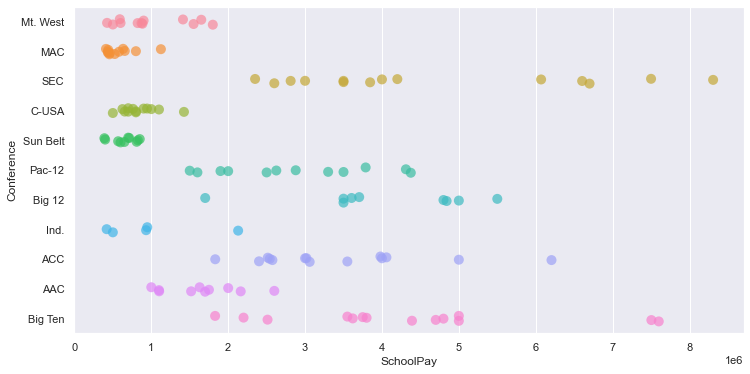

In [18]:
# Visualizations - Conference
# Variable chosen = SchoolPay
sns.set(rc={'figure.figsize':(12,6)}) # set figure dimensions 

sns.stripplot(data = merged
             , x = "SchoolPay"
             , y = "Conference"
             , dodge = True
              , size = 10
              , alpha = 0.7
             )

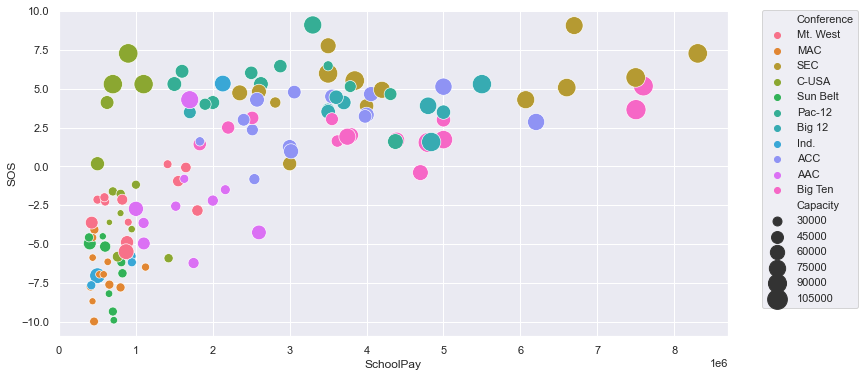

In [19]:
# Visualizations - SOS
sns.scatterplot(data = merged
            , x = "SchoolPay"
            , y = "SOS"
            , hue = "Conference"
            , size = "Capacity"
            , sizes = (40, 400)
           )

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

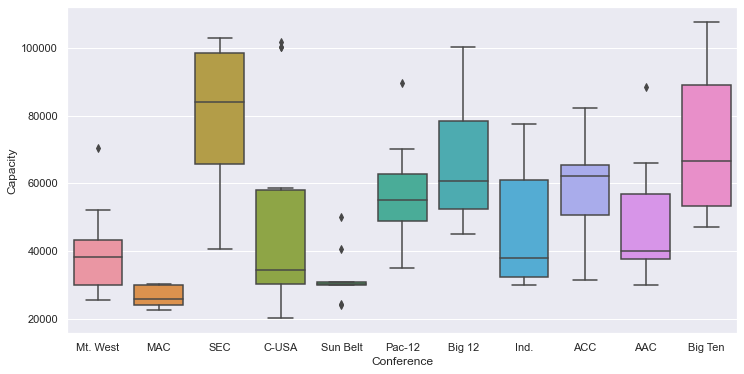

In [20]:
# Visualizations - Capacity

#print(merged[merged['GSR']== 0.0])
merged = merged[merged['GSR'] != 0.0]

sns.boxplot(data=merged, x="Conference", y="Capacity")

99.0
52.0


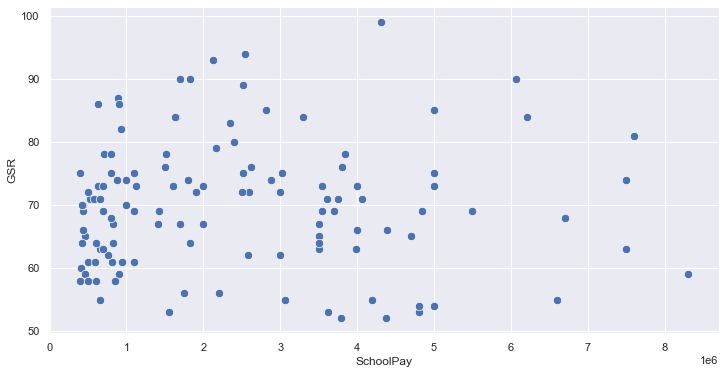

In [21]:
# Visualizations - Grad Rate
sns.scatterplot(data = merged
                , x = "SchoolPay"
                , y = "GSR"
                , s = 70
               )

print(merged['GSR'].max())
print(merged['GSR'].min())

In [22]:
# Modeling - split data into test/train sets

merged['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(merged))

coach_train = merged[merged['runiform'] >= 0.33]
coach_test = merged[merged['runiform'] < 0.33]

# train data dimensions
#print(coach_train.head())
print(len(coach_train))

# test data dimensions
#print(coach_test.head())
print(len(coach_test))


84
44


In [23]:
# Modeling - create regression model (SRS only with Conference, Capacity, GSR) 
model = str('SchoolPay ~ SRS + Conference + Capacity + GSR')

# fit model to training data
train_model = smf.ols(model, data = coach_train, missing = 'drop').fit()

# model summary
print(train_model.summary())

                            OLS Regression Results                            
Dep. Variable:              SchoolPay   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     17.49
Date:                Sat, 24 Jul 2021   Prob (F-statistic):           1.05e-16
Time:                        16:00:38   Log-Likelihood:                -1215.4
No. Observations:                  81   AIC:                             2459.
Df Residuals:                      67   BIC:                             2492.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1.88

In [24]:
# Modeling - create regression model (SRS components with Conference, Capcity, GSR)
model2 = str('SchoolPay ~ SOS + Off + Def + Conference + Capacity + GSR')

# fit model to training data
train_model2 = smf.ols(model2, data = coach_train, missing = 'drop').fit()

# model summary
print(train_model2.summary())

                            OLS Regression Results                            
Dep. Variable:              SchoolPay   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     15.60
Date:                Sat, 24 Jul 2021   Prob (F-statistic):           4.49e-16
Time:                        16:00:38   Log-Likelihood:                -1213.5
No. Observations:                  81   AIC:                             2459.
Df Residuals:                      65   BIC:                             2497.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               8.48

In [25]:
# Modeling - create regression model (SRS components without GSR)
model3 = str('SchoolPay ~ SOS + Off + Def + Conference + Capacity')

# fit model to training data
train_model3 = smf.ols(model3, data = coach_train, missing = 'drop').fit()

# model summary
print(train_model3.summary())

                            OLS Regression Results                            
Dep. Variable:              SchoolPay   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     16.74
Date:                Sat, 24 Jul 2021   Prob (F-statistic):           1.48e-16
Time:                        16:00:38   Log-Likelihood:                -1214.0
No. Observations:                  81   AIC:                             2458.
Df Residuals:                      66   BIC:                             2494.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               8.83

In [26]:
# Modeling - create regression model (SRS + components + Pct + GSR)
#model4 = str('SchoolPay ~ SRS + SOS + Off + Def + Conference + Capacity + Pct + GSR')

# fit model to training data
#train_model4 = smf.ols(model4, data = coach_train, missing = 'drop').fit()

# model summary
#print(train_model4.summary())

In [33]:
# Modeling - get training set predictions
coach_train['prediction'] = train_model2.fittedvalues

coach_train.head()

<ipython-input-33-be3a497ac74b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coach_train['prediction'] = train_model2.fittedvalues


,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,W,...,Def,SRS,SOS,Stadium,Capacity,Opened,State,GSR,runiform,prediction
2,Alabama A&M University,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,500000.0,0.0,33600000.0,12.0,...,18.4,20.34,7.27,Bryant Denny Stadium,101821.0,1929,AL,59.0,0.874037,5.057386e+06
3,Alabama A&M University,C-USA,Bill Clark,900000.0,900000.0,950000.0,165471.0,0.0,3847500.0,12.0,...,18.4,20.34,7.27,Bryant Denny Stadium,101821.0,1929,AL,59.0,0.726468,2.141793e+06
4,Appalachian State University,Sun Belt,Scott Satterfield,712500.0,712500.0,295000.0,145000.0,0.0,2160417.0,7.0,...,27.3,-6.56,-9.90,Kidd Brewer Stadium,24150.0,1962,NC,78.0,0.387677,6.123392e+05
5,Arizona State University,Pac-12,Kevin Sumlin,1600000.0,2000000.0,2025000.0,NaN,0.0,10000000.0,10.0,...,28.2,11.90,6.12,Arizona Stadium,56037.0,1928,AZ,73.0,0.944656,2.551697e+06
6,Arizona State University,Pac-12,Herm Edwards,2000000.0,2000000.0,3010000.0,NaN,0.0,8166667.0,10.0,...,27.9,13.26,4.11,Sun Devil Stadium,56232.0,1958,AZ,73.0,0.920932,2.699386e+06


In [34]:
# Modeling - get predictions for test set 
coach_test['prediction'] = train_model2.predict(coach_test)

coach_test.head()

<ipython-input-34-159fedec654c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coach_test['prediction'] = train_model2.predict(coach_test)


,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,W,...,Def,SRS,SOS,Stadium,Capacity,Opened,State,GSR,runiform,prediction
0,U.S. Air Force Academy,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,NaN,0.0,NaN,10.0,...,24.2,2.20,-4.88,Falcon Stadium,52237.0,1962,CO,87.0,0.100686,1.367445e+06
1,University of Akron,MAC,Terry Bowden,411000.0,412500.0,225000.0,50000.0,0.0,688500.0,5.0,...,23.1,-9.23,-7.73,InfoCision Stadium,30000.0,2009,OH,60.0,0.090459,7.101057e+05
8,Arkansas State University,SEC,Chad Morris,3500000.0,3500000.0,1000000.0,NaN,0.0,12500000.0,7.0,...,19.2,14.91,7.76,Razorback Stadium,72000.0,1938,AR,67.0,0.296688,4.149630e+06
14,Auburn University,SEC,Gus Malzahn,6700000.0,6705656.0,1400000.0,375000.0,0.0,32143750.0,8.0,...,26.7,14.99,9.06,Jordan Hare Stadium,87451.0,1939,AL,68.0,0.054389,4.460731e+06
15,Ball State University,MAC,Mike Neu,435689.0,435689.0,380000.0,30000.0,0.0,980300.0,5.0,...,27.2,-8.35,-8.68,Scheumann Stadium,22500.0,1967,IN,69.0,0.055364,6.267828e+05


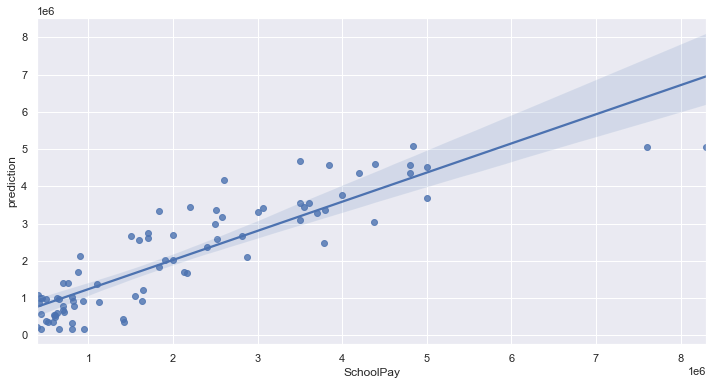

In [35]:
# Modeling - regression plot training data

sns.regplot(x = "SchoolPay", y = "prediction", data = coach_train)

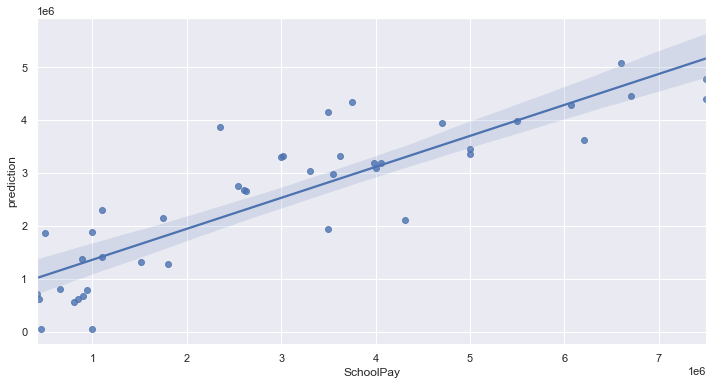

In [36]:
# Modeling - regression plot test data
sns.regplot(x = "SchoolPay", y = "prediction", data = coach_test)

In [64]:
# Prediction - predict Syracuse coach salary 

cuse = merged[merged['School'] == 'Syracuse University']

train_model2.predict(cuse)

110    2.368859e+06
dtype: float64

In [66]:
cuse.at[110, 'Conference'] = 'Big Ten'
cuse

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,W,...,Off,Def,SRS,SOS,Stadium,Capacity,Opened,State,GSR,runiform
110,Syracuse University,Big Ten,Dino Babers,2401206.0,2401206.0,NaN,NaN,0.0,NaN,3.0,...,17.1,24.3,-4.84,3.0,Carrier Dome,49250.0,1980,NY,80.0,0.485014


In [67]:
train_model2.predict(cuse)

110    2.882778e+06
dtype: float64